# 네이버 영화평 감성분석 - 경진대회
- 출처: [데이터 다운로드 링크](https://github.com/e9t/nsmc/)

In [1]:
# Konlpy 설치
!pip install Konlpy

     |████████████████████████████████| 19.4MB 1.3MB/s 
     |████████████████████████████████| 460kB 53.0MB/s 
     |████████████████████████████████| 92kB 13.6MB/s 
  Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3
  Found existing installation: tweepy 3.6.0
    Uninstalling tweepy-3.6.0:
      Successfully uninstalled tweepy-3.6.0


In [2]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [3]:
seed = 2021
np.random.seed(seed)
tf.random.set_seed(seed)

### 파일 업로드

In [4]:
from google.colab import files

uploaded = files.upload()
filename = list(uploaded.keys())[0]

Saving ratings_train.txt to ratings_train.txt


In [5]:
uploaded = files.upload()
testfile = list(uploaded.keys())[0]

Saving ratings_test.txt to ratings_test.txt


### 데이터 전처리

In [6]:
import pandas as pd
train_df = pd.read_table(filename)
test_df = pd.read_table(testfile)

In [7]:
train_df.head(3)

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0


In [8]:
# 중복 여부 확인
train_df['document'].nunique()

146182

In [9]:
# 중복 샘플 제거
train_df.drop_duplicates(subset=['document'], inplace=True)
train_df.shape

(146183, 3)

In [10]:
# Null값 확인
train_df.isnull().sum()

id          0
document    1
label       0
dtype: int64

In [11]:
# Null값 제거
train_df = train_df.dropna(how = 'any')
train_df.shape

(146182, 3)

In [12]:
# 긍정, 부정 레이블 값의 갯수
train_df.label.value_counts()

0    73342
1    72840
Name: label, dtype: int64

In [13]:
# 중복 제거
test_df.drop_duplicates(subset=['document'], inplace=True)
test_df.shape

(49158, 3)

In [14]:
# Null 제거
test_df = test_df.dropna(how='any')
test_df.shape

(49157, 3)

### 한글 텍스트 전처리

In [15]:
train_df['document'] = train_df['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
train_df.head(3)

,id,document,label
0,9976970,아 더빙 진짜 짜증나네요 목소리,0
1,3819312,흠포스터보고 초딩영화줄오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0


In [16]:
train_df['document'].replace('', np.nan, inplace=True)
train_df.isnull().sum()

id            0
document    391
label         0
dtype: int64

In [17]:
train_df = train_df.dropna(how = 'any')
train_df.shape

(145791, 3)

- 테스트 데이터 셋

In [18]:
test_df['document'] = test_df['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
test_df['document'].replace('', np.nan, inplace=True)
test_df.isnull().sum()

id            0
document    162
label         0
dtype: int64

In [19]:
test_df = test_df.dropna(how = 'any')
test_df.shape

(48995, 3)

### 한글 형태소 분석

In [20]:
from konlpy.tag import Okt
import tqdm.notebook as tn

In [21]:
# 토큰화와 불용어 제거
stopwords=['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']
okt = Okt()

X_train=[]
for sentence in tn.tqdm(train_df['document']):
    temp_X = []
    temp_X = okt.morphs(sentence, stem=True)    # 토큰화
    temp_X = [word for word in temp_X if not word in stopwords]     # 불용어 제거
    X_train.append(temp_X)

In [22]:
X_test=[]
for sentence in tn.tqdm(test_df['document']):
    temp_X = []
    temp_X = okt.morphs(sentence, stem=True)    # 토큰화
    temp_X = [word for word in temp_X if not word in stopwords]     # 불용어 제거
    X_test.append(temp_X)

In [25]:
X_train[:3]

[['아', '더빙', '진짜', '짜증나다', '목소리'],
 ['흠', '포스터', '보고', '초딩', '영화', '줄', '오버', '연기', '조차', '가볍다', '않다'],
 ['너', '무재', '밓었', '다그', '래서', '보다', '추천', '다']]

### 케라스 인코딩

In [26]:
# 정수 인코딩
max_words = 35000
tokenizer = Tokenizer(num_words=max_words) # 상위 35,000개의 단어만 보존
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [27]:
X_train[:3]

[[50, 454, 16, 260, 659],
 [933, 457, 41, 602, 1, 214, 1449, 24, 961, 675, 19],
 [386, 2444, 25015, 2315, 5671, 2, 222, 9]]

In [28]:
# 전체 데이터의 길이 분포
print('리뷰의 최대 길이 :', max(len(s) for s in X_train))
print('리뷰의 평균 길이 :', sum(map(len, X_train))/len(X_train))

리뷰의 최대 길이 : 69
리뷰의 평균 길이 : 10.911133060339802


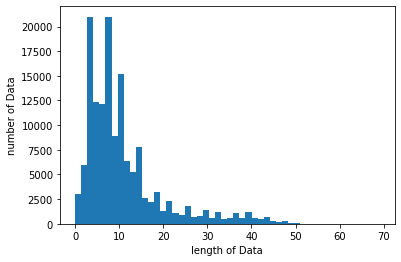

In [29]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.hist([len(s) for s in X_train], bins=50)
plt.xlabel('length of Data')
plt.ylabel('number of Data')
plt.show()

In [30]:
#  X_train과 X_test의 모든 샘플의 길이를 동일하게 30으로 셋팅
max_len=30
# 전체 데이터의 길이는 30으로 맞춘다.
X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

In [37]:
Y_train = train_df['label'].values
Y_test = test_df['label'].values

### 모델 정의/설정/학습/평가

In [32]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense

#### (1) LSTM

In [33]:
from tensorflow.keras.layers import LSTM

- Embedding layer size: 100
- LSTM layer size: 128

In [64]:
model = Sequential([
    Embedding(max_words, 100),
    LSTM(128),
    Dense(1, activation='sigmoid')
])
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, None, 100)         3500000   
_________________________________________________________________
lstm_5 (LSTM)                (None, 128)               117248    
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 129       
Total params: 3,617,377
Trainable params: 3,617,377
Non-trainable params: 0
_________________________________________________________________


In [65]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [66]:
from tensorflow.keras.callbacks import ModelCheckpoint
modelpath = "model/naver-lstm-{epoch:02d}-{val_loss:.4f}.hdf5"
checkpointer = ModelCheckpoint(filepath=modelpath, monitor='val_loss', 
                               verbose=1, save_best_only=True)

In [67]:
history = model.fit(X_train, Y_train, epochs=4, batch_size=60,
                    validation_split=0.2, verbose=1, callbacks=[checkpointer])

Epoch 1/4
1944/1944 [==============================] - 63s 32ms/step - loss: 0.4363 - accuracy: 0.7922 - val_loss: 0.3519 - val_accuracy: 0.8457

Epoch 00001: val_loss improved from inf to 0.35185, saving model to model/naver-lstm-01-0.3519.hdf5
Epoch 2/4
1944/1944 [==============================] - 61s 31ms/step - loss: 0.2856 - accuracy: 0.8797 - val_loss: 0.3406 - val_accuracy: 0.8525

Epoch 00002: val_loss improved from 0.35185 to 0.34061, saving model to model/naver-lstm-02-0.3406.hdf5
Epoch 3/4
1944/1944 [==============================] - 60s 31ms/step - loss: 0.2268 - accuracy: 0.9083 - val_loss: 0.3750 - val_accuracy: 0.8501

Epoch 00003: val_loss did not improve from 0.34061
Epoch 4/4
1944/1944 [==============================] - 60s 31ms/step - loss: 0.1797 - accuracy: 0.9273 - val_loss: 0.4149 - val_accuracy: 0.8468

Epoch 00004: val_loss did not improve from 0.34061


In [68]:
# Best Model 선택
from keras.models import load_model
best_model = load_model('model/naver-lstm-02-0.3406.hdf5')
del model

In [69]:
acc = best_model.evaluate(X_test, Y_test, verbose=2)[1]
print(f'Accuracy: {acc:.4f}')

1532/1532 - 4s - loss: 0.3483 - accuracy: 0.8487
Accuracy: 0.8487


- Embedding layer size: 100
- LSTM layer size: 256

In [58]:
model = Sequential([
    Embedding(max_words, 100),
    LSTM(256),
    Dense(1, activation='sigmoid')
])
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, None, 100)         3500000   
_________________________________________________________________
lstm_4 (LSTM)                (None, 256)               365568    
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 257       
Total params: 3,865,825
Trainable params: 3,865,825
Non-trainable params: 0
_________________________________________________________________


In [59]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [60]:
modelpath = "model/naver-lstm-{epoch:02d}-{val_loss:.4f}_2.hdf5"
checkpointer = ModelCheckpoint(filepath=modelpath, monitor='val_loss', 
                               verbose=1, save_best_only=True)

In [61]:
history = model.fit(X_train, Y_train, epochs=4, batch_size=60,
                    validation_split=0.2, verbose=1, callbacks=[checkpointer])

Epoch 1/4
1944/1944 [==============================] - 68s 34ms/step - loss: 0.4397 - accuracy: 0.7888 - val_loss: 0.3507 - val_accuracy: 0.8466

Epoch 00001: val_loss improved from inf to 0.35073, saving model to model/naver-lstm-01-0.3507_2.hdf5
Epoch 2/4
1944/1944 [==============================] - 65s 34ms/step - loss: 0.2834 - accuracy: 0.8803 - val_loss: 0.3435 - val_accuracy: 0.8514

Epoch 00002: val_loss improved from 0.35073 to 0.34350, saving model to model/naver-lstm-02-0.3435_2.hdf5
Epoch 3/4
1944/1944 [==============================] - 66s 34ms/step - loss: 0.2261 - accuracy: 0.9085 - val_loss: 0.3809 - val_accuracy: 0.8477

Epoch 00003: val_loss did not improve from 0.34350
Epoch 4/4
1944/1944 [==============================] - 65s 33ms/step - loss: 0.1800 - accuracy: 0.9277 - val_loss: 0.4153 - val_accuracy: 0.8436

Epoch 00004: val_loss did not improve from 0.34350


In [62]:
best_model = load_model('model/naver-lstm-02-0.3435_2.hdf5')
del model

In [63]:
acc = best_model.evaluate(X_test, Y_test, verbose=2)[1]
print(f'Accuracy: {acc:.4f}')

1532/1532 - 4s - loss: 0.3510 - accuracy: 0.8473
Accuracy: 0.8473


- Embedding layer size: 200
- LSTM layer size: 256

In [71]:
model = Sequential([
    Embedding(max_words, 200),
    LSTM(256),
    Dense(1, activation='sigmoid')
])
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, None, 200)         7000000   
_________________________________________________________________
lstm_6 (LSTM)                (None, 256)               467968    
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 257       
Total params: 7,468,225
Trainable params: 7,468,225
Non-trainable params: 0
_________________________________________________________________


In [72]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [73]:
modelpath = "model/naver-lstm-{epoch:02d}-{val_loss:.4f}_3.hdf5"
checkpointer = ModelCheckpoint(filepath=modelpath, monitor='val_loss', 
                               verbose=1, save_best_only=True)

In [74]:
history = model.fit(X_train, Y_train, epochs=4, batch_size=60,
                    validation_split=0.2, verbose=1, callbacks=[checkpointer])

Epoch 1/4
1944/1944 [==============================] - 131s 66ms/step - loss: 0.4326 - accuracy: 0.7932 - val_loss: 0.3486 - val_accuracy: 0.8476

Epoch 00001: val_loss improved from inf to 0.34859, saving model to model/naver-lstm-01-0.3486_3.hdf5
Epoch 2/4
1944/1944 [==============================] - 128s 66ms/step - loss: 0.2731 - accuracy: 0.8852 - val_loss: 0.3427 - val_accuracy: 0.8514

Epoch 00002: val_loss improved from 0.34859 to 0.34267, saving model to model/naver-lstm-02-0.3427_3.hdf5
Epoch 3/4
1944/1944 [==============================] - 128s 66ms/step - loss: 0.2101 - accuracy: 0.9158 - val_loss: 0.3853 - val_accuracy: 0.8478

Epoch 00003: val_loss did not improve from 0.34267
Epoch 4/4
1944/1944 [==============================] - 128s 66ms/step - loss: 0.1546 - accuracy: 0.9387 - val_loss: 0.4455 - val_accuracy: 0.8450

Epoch 00004: val_loss did not improve from 0.34267


In [75]:
best_model = load_model('model/naver-lstm-02-0.3427_3.hdf5')
del model

In [76]:
acc = best_model.evaluate(X_test, Y_test, verbose=2)[1]
print(f'Accuracy: {acc:.4f}')

1532/1532 - 4s - loss: 0.3496 - accuracy: 0.8477
Accuracy: 0.8477


#### (2) SimpleRNN

In [77]:
from tensorflow.keras.layers import SimpleRNN

- Embedding layer size: 100
- SimpleRNN layer size: 100

In [85]:
model = Sequential([
    Embedding(max_words, 100),
    SimpleRNN(100),
    Dense(1, activation='sigmoid')
])
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, None, 100)         3500000   
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 100)               20100     
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 101       
Total params: 3,520,201
Trainable params: 3,520,201
Non-trainable params: 0
_________________________________________________________________


In [86]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
modelpath = "model/naver-rnn-{epoch:02d}-{val_loss:.4f}.hdf5"
checkpointer = ModelCheckpoint(filepath=modelpath, monitor='val_loss', 
                               verbose=1, save_best_only=True)

In [88]:
model.fit(X_train, Y_train, epochs=4, batch_size=60, 
          validation_split=0.2, verbose=1, callbacks=[checkpointer])

Epoch 1/4
1944/1944 [==============================] - 100s 51ms/step - loss: 0.4622 - accuracy: 0.7677 - val_loss: 0.3689 - val_accuracy: 0.8384

Epoch 00001: val_loss improved from inf to 0.36886, saving model to model/naver-rnn-01-0.3689.hdf5
Epoch 2/4
1944/1944 [==============================] - 98s 51ms/step - loss: 0.3015 - accuracy: 0.8742 - val_loss: 0.3778 - val_accuracy: 0.8369

Epoch 00002: val_loss did not improve from 0.36886
Epoch 3/4
1944/1944 [==============================] - 96s 50ms/step - loss: 0.2064 - accuracy: 0.9184 - val_loss: 0.4446 - val_accuracy: 0.8173

Epoch 00003: val_loss did not improve from 0.36886
Epoch 4/4
1944/1944 [==============================] - 97s 50ms/step - loss: 0.1503 - accuracy: 0.9425 - val_loss: 0.5433 - val_accuracy: 0.8135

Epoch 00004: val_loss did not improve from 0.36886


In [90]:
best_model = load_model('model/naver-rnn-01-0.3689.hdf5')
del model

acc = best_model.evaluate(X_test, Y_test, verbose=2)[1]
print(f'Accuracy: {acc:.4f}')

1532/1532 - 6s - loss: 0.3737 - accuracy: 0.8362
Accuracy: 0.8362


#### (3) GRU

In [91]:
from tensorflow.keras.layers import GRU

- Embedding layer size: 100
- GRU layer size: 128

In [92]:
model = Sequential([
    Embedding(max_words, 100),
    GRU(128),
    Dense(1, activation='sigmoid')
])
model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, None, 100)         3500000   
_________________________________________________________________
gru_1 (GRU)                  (None, 128)               88320     
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 129       
Total params: 3,588,449
Trainable params: 3,588,449
Non-trainable params: 0
_________________________________________________________________


In [93]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
modelpath = "model/naver-gru-{epoch:02d}-{val_loss:.4f}.hdf5"
checkpointer = ModelCheckpoint(filepath=modelpath, monitor='val_loss', 
                               verbose=1, save_best_only=True)

In [94]:
model.fit(X_train, Y_train, epochs=4, batch_size=60, 
          validation_split=0.2, verbose=1, callbacks=[checkpointer])

Epoch 1/4
1944/1944 [==============================] - 61s 31ms/step - loss: 0.4319 - accuracy: 0.7943 - val_loss: 0.3431 - val_accuracy: 0.8489

Epoch 00001: val_loss improved from inf to 0.34308, saving model to model/naver-gru-01-0.3431.hdf5
Epoch 2/4
1944/1944 [==============================] - 59s 31ms/step - loss: 0.2769 - accuracy: 0.8836 - val_loss: 0.3404 - val_accuracy: 0.8504

Epoch 00002: val_loss improved from 0.34308 to 0.34037, saving model to model/naver-gru-02-0.3404.hdf5
Epoch 3/4
1944/1944 [==============================] - 60s 31ms/step - loss: 0.2174 - accuracy: 0.9132 - val_loss: 0.3751 - val_accuracy: 0.8475

Epoch 00003: val_loss did not improve from 0.34037
Epoch 4/4
1944/1944 [==============================] - 60s 31ms/step - loss: 0.1686 - accuracy: 0.9339 - val_loss: 0.4329 - val_accuracy: 0.8459

Epoch 00004: val_loss did not improve from 0.34037


In [95]:
best_model = load_model('model/naver-gru-02-0.3404.hdf5')
del model

acc = best_model.evaluate(X_test, Y_test, verbose=2)[1]
print(f'Accuracy: {acc:.4f}')

1532/1532 - 4s - loss: 0.3466 - accuracy: 0.8480
Accuracy: 0.8480


- Embedding layer size: 100
- GRU layer size: 256

In [96]:
model = Sequential([
    Embedding(max_words, 100),
    GRU(256),
    Dense(1, activation='sigmoid')
])
model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_11 (Embedding)     (None, None, 100)         3500000   
_________________________________________________________________
gru_2 (GRU)                  (None, 256)               274944    
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 257       
Total params: 3,775,201
Trainable params: 3,775,201
Non-trainable params: 0
_________________________________________________________________


In [97]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
modelpath = "model/naver-gru-{epoch:02d}-{val_loss:.4f}_2.hdf5"
checkpointer = ModelCheckpoint(filepath=modelpath, monitor='val_loss', 
                               verbose=1, save_best_only=True)

In [98]:
model.fit(X_train, Y_train, epochs=4, batch_size=60, 
          validation_split=0.2, verbose=1, callbacks=[checkpointer])

Epoch 1/4
1944/1944 [==============================] - 65s 32ms/step - loss: 0.4337 - accuracy: 0.7931 - val_loss: 0.3433 - val_accuracy: 0.8491

Epoch 00001: val_loss improved from inf to 0.34329, saving model to model/naver-gru-01-0.3433_2.hdf5
Epoch 2/4
1944/1944 [==============================] - 62s 32ms/step - loss: 0.2748 - accuracy: 0.8857 - val_loss: 0.3415 - val_accuracy: 0.8509

Epoch 00002: val_loss improved from 0.34329 to 0.34149, saving model to model/naver-gru-02-0.3415_2.hdf5
Epoch 3/4
1944/1944 [==============================] - 62s 32ms/step - loss: 0.2148 - accuracy: 0.9141 - val_loss: 0.3775 - val_accuracy: 0.8501

Epoch 00003: val_loss did not improve from 0.34149
Epoch 4/4
1944/1944 [==============================] - 62s 32ms/step - loss: 0.1632 - accuracy: 0.9361 - val_loss: 0.4370 - val_accuracy: 0.8442

Epoch 00004: val_loss did not improve from 0.34149


In [99]:
best_model = load_model('model/naver-gru-02-0.3415_2.hdf5')
del model

acc = best_model.evaluate(X_test, Y_test, verbose=2)[1]
print(f'Accuracy: {acc:.4f}')

1532/1532 - 4s - loss: 0.3477 - accuracy: 0.8472
Accuracy: 0.8472


#### (4) CNN + GRU 

In [101]:
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dropout

In [118]:
model = Sequential([
    Embedding(max_words, 128),
    Dropout(0.5),
    Conv1D(64, 5, padding='valid', activation='relu'),
    MaxPooling1D(pool_size=4),
    GRU(64),
    Dense(1, activation='sigmoid')
])
model.summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_17 (Embedding)     (None, None, 128)         4480000   
_________________________________________________________________
dropout_5 (Dropout)          (None, None, 128)         0         
_________________________________________________________________
conv1d_7 (Conv1D)            (None, None, 64)          41024     
_________________________________________________________________
max_pooling1d_7 (MaxPooling1 (None, None, 64)          0         
_________________________________________________________________
gru_3 (GRU)                  (None, 64)                24960     
_________________________________________________________________
dense_16 (Dense)             (None, 1)                 65        
Total params: 4,546,049
Trainable params: 4,546,049
Non-trainable params: 0
___________________________________________

In [119]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
modelpath = "model/naver-cnn-lstm-{epoch:02d}-{val_loss:.4f}.hdf5"
checkpointer = ModelCheckpoint(filepath=modelpath, monitor='val_loss', 
                               verbose=1, save_best_only=True)

In [120]:
model.fit(X_train, Y_train, epochs=4, batch_size=60, 
          validation_split=0.2, verbose=1, callbacks=[checkpointer])

Epoch 1/4
1944/1944 [==============================] - 80s 40ms/step - loss: 0.5342 - accuracy: 0.7092 - val_loss: 0.4456 - val_accuracy: 0.7774

Epoch 00001: val_loss improved from inf to 0.44561, saving model to model/naver-cnn-lstm-01-0.4456.hdf5
Epoch 2/4
1944/1944 [==============================] - 77s 40ms/step - loss: 0.3977 - accuracy: 0.8110 - val_loss: 0.4441 - val_accuracy: 0.7790

Epoch 00002: val_loss improved from 0.44561 to 0.44411, saving model to model/naver-cnn-lstm-02-0.4441.hdf5
Epoch 3/4
1944/1944 [==============================] - 76s 39ms/step - loss: 0.3406 - accuracy: 0.8396 - val_loss: 0.4628 - val_accuracy: 0.7753

Epoch 00003: val_loss did not improve from 0.44411
Epoch 4/4
1944/1944 [==============================] - 74s 38ms/step - loss: 0.2978 - accuracy: 0.8593 - val_loss: 0.5010 - val_accuracy: 0.7742

Epoch 00004: val_loss did not improve from 0.44411


In [117]:
best_model = load_model('model/naver-cnn-lstm-02-0.4434.hdf5')
del model

acc = best_model.evaluate(X_test, Y_test, verbose=2)[1]
print(f'Accuracy: {acc:.4f}')

1532/1532 - 3s - loss: 0.4526 - accuracy: 0.7723
Accuracy: 0.7723


### 결과 종합
- (1) LSTM
    - Embedding layer size: 100 / LSTM layer size: 128 --> 0.8487
    - Embedding layer size: 100 / LSTM layer size: 256 --> 0.8473

- (2) SimpleRNN
    - Embedding layer size: 100 / SimpleRNN layer size: 100 -> 0.8362

- (3) GRU
    - Embedding layer size: 100 / GRU layer size: 128 -> 0.8480
    - Embedding layer size: 100 / GRU layer size: 256 -> 0.8472

- (4) Conv1D + GRU
    - Embedding layer size: 128 / Dropout(0.5) / Conv1D(64, 5) / MaxPooling1D(pool_size=4) / GRU layer size: 64 -> 0.7723